# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

In [1]:
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.1 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Load Data

In [25]:
# Load data
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Preparing features (`X`) & target (`y`)

In [26]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [27]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

# Your Work

## Data Exploration

In [28]:
# Checking for nulls again

df.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
Recommended IND            0
dtype: int64

In [29]:
# Getting statistics for data

X.describe()

,Clothing ID,Age,Positive Feedback Count
count,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484
std,141.571783,12.246264,5.942220
min,2.000000,18.000000,0.000000
25%,863.000000,34.000000,0.000000
50%,952.000000,41.000000,1.000000
75%,1078.000000,52.000000,3.000000
max,1205.000000,99.000000,122.000000


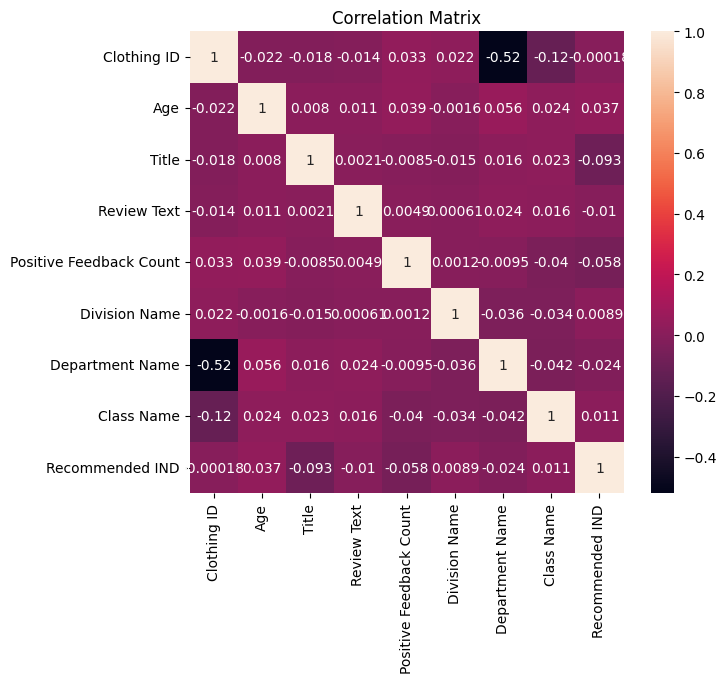

Recommended IND            1.000000
Age                        0.036656
Class Name                 0.010550
Division Name              0.008875
Clothing ID               -0.000180
Review Text               -0.009997
Department Name           -0.024077
Positive Feedback Count   -0.058392
Title                     -0.093143
Name: Recommended IND, dtype: float64

In [30]:
# Correlation matrix

ordinal_encoder = OrdinalEncoder()
temp_df = df.copy()
for c in temp_df.columns:
    if temp_df[c].dtype == 'object':
        column = pd.DataFrame(temp_df[c]) 
        temp_df[c] = ordinal_encoder.fit_transform(column)

corr_matrix = temp_df.corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

corr_matrix["Recommended IND"].sort_values(ascending=False)

## Building Pipeline

### Numerical Data

In [31]:
# split data into numerical and categorical features
num_features = X.select_dtypes(exclude=['object']).columns
print('Numerical features:', num_features)

Numerical features: Index(['Clothing ID', 'Age', 'Positive Feedback Count'], dtype='object')


In [32]:
# Scale numerical features
num_pipeline = Pipeline([("scaler", MinMaxScaler())])

num_pipeline

Pipeline(steps=[('scaler', MinMaxScaler())])

### Categorical Data

In [33]:
# Split categorical data out

cat_features = (
    X[[
        'Class Name',
        'Division Name',
        'Department Name',
    ]].columns
)

cat_features

Index(['Class Name', 'Division Name', 'Department Name'], dtype='object')

In [36]:
# One hot encoder for categorical data

cat_pipeline = Pipeline([    
        ("cat_encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ])

cat_pipeline

Pipeline(steps=[('cat_encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

### Text Data

In [34]:
# Split review text data out

text_features = (
    X[[
        'Review Text',
    ]].columns
)

text_features

Index(['Review Text'], dtype='object')

In [35]:
# Split title data out

title_col = (
    X[[
        'Title',
    ]].columns
)

title_col

Index(['Title'], dtype='object')

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
# Takes in a string for the character to count
# Outputs the number times that character appears in the text

class CountCharacter(BaseEstimator, TransformerMixin):
    def __init__(self, character: str):
        self.character = character

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[text.count(self.character)] for text in X]

In [38]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Counts number of spaces, exclamation points, and question marks in text data

initial_text_preprocess = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
])

feature_engineering = FeatureUnion([
    ('count_spaces', CountCharacter(character=' ')),
    ('count_exclamations', CountCharacter(character='!')),
    ('count_question_marks', CountCharacter(character='?')),
])

character_counts_pipeline = Pipeline([
    (
        'initial_text_preprocess',
        initial_text_preprocess,
    ),
    (
        'feature_engineering',
        feature_engineering,
    ),
])

character_counts_pipeline

Pipeline(steps=[('initial_text_preprocess',
                 Pipeline(steps=[('dimension_reshaper',
                                  FunctionTransformer(func=<function reshape at 0x78a878142570>,
                                                      kw_args={'newshape': -1}))])),
                ('feature_engineering',
                 FeatureUnion(transformer_list=[('count_spaces',
                                                 CountCharacter(character=' ')),
                                                ('count_exclamations',
                                                 CountCharacter(character='!')),
                                                ('count_question_marks',
                                                 CountCharacter(character='?'))]))])

In [39]:
class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    # Takes in a string for the character to count
# Outputs the number times that character appears in the text
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmatized = [
            ' '.join(
                token.lemma_ for token in doc
                if not token.is_stop
            )
            for doc in self.nlp.pipe(X)
        ]
        return lemmatized   

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy

nlp = spacy.load('en_core_web_sm')

tfidf_pipeline = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
    (
        'lemmatizer',
        SpacyLemmatizer(nlp=nlp),
    ),
    (
        'tfidf_vectorizer',
        TfidfVectorizer(
            stop_words='english',
        ),
    ),
])

tfidf_pipeline 

Pipeline(steps=[('dimension_reshaper',
                 FunctionTransformer(func=<function reshape at 0x78a878142570>,
                                     kw_args={'newshape': -1})),
                ('lemmatizer',
                 SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x78a7e8e87490>)),
                ('tfidf_vectorizer', TfidfVectorizer(stop_words='english'))])

In [42]:
feature_engineering = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('character_counts', character_counts_pipeline, text_features),
        ('tfidf_text', tfidf_pipeline, text_features),
        ('title_char_counts', character_counts_pipeline, title_col),
        ('title_tfidf', tfidf_pipeline, title_col),
])

feature_engineering

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 Index(['Clothing ID', 'Age', 'Positive Feedback Count'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Class Name', 'Division Name', 'Department Name'], dtype='object')),
                                ('character_counts',
                                 Pipeline(s...
                                                                                  CountCharacter(character='?'))]))]),
                                 Index(['Title'], dtype='object')),
                                ('title_tfidf',
                                 Pipeline(steps=[('dimension_reshaper',
                                                  FunctionTransformer(func=<function reshape at 0x78a878142570>,
                                                                      kw_args={'newshape': -1})),
                                                 ('lemmatizer',
                                                  SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x78a7e8e87490>)),
                                                 ('tfidf_vectorizer',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 Index(['Title'], dtype='object'))])

## Training Pipeline

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

model_pipeline = make_pipeline(
    feature_engineering,
    RandomForestClassifier(random_state=27),
)

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Clothing ID', 'Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Class Name', 'Division Name', 'Department Name'], dtype='obj...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x78a878142570>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x78a7e8e87490>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Title'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=27))])

In [44]:
y_pred_forest_pipeline = model_pipeline.predict(X_test)
accuracy_forest_pipeline = accuracy_score(y_test, y_pred_forest_pipeline)

print('Accuracy:', accuracy_forest_pipeline)

Accuracy: 0.8569105691056911


## Fine-Tuning Pipeline

In [45]:
# TODO: set parameters to randomly search over
# A couple parameters with 2-5 options each is plenty
my_distributions = dict(
    randomforestclassifier__max_features=[
        100,
        150,
        250,
    ],
    randomforestclassifier__n_estimators=[
        150,
        200,
    ],
)

param_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=my_distributions,
    n_iter=6,     # Try 6 different combinations of parameters
    cv=5,         # Use 5-fold cross-validation
    n_jobs=-1,    # Use all available processors (for multiprocessing)
    refit=True,   # Refit the model using the best parameters found
    verbose=3,    # Output of parameters, score, time
    random_state=27,
)

param_search.fit(X_train, y_train)

# Retrieve the best parameters
param_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.857 total time= 1.9min
[CV 2/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.858 total time= 1.9min
[CV 3/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.851 total time= 1.9min
[CV 4/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.851 total time= 1.9min
[CV 5/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=150;, score=0.852 total time= 1.9min
[CV 1/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=200;, score=0.855 total time= 1.9min
[CV 2/5] END randomforestclassifier__max_features=100, randomforestclassifier__n_estimators=200;, score=0.858 total time= 2.0min
[CV 3/5] END randomforestclassifier__

{'randomforestclassifier__n_estimators': 150,
 'randomforestclassifier__max_features': 250}

In [46]:
model_best = param_search.best_estimator_
model_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Clothing ID', 'Age', 'Positive Feedback Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Class Name', 'Division Name', 'Department Name'], dtype='obj...
                                                                   FunctionTransformer(func=<function reshape at 0x78a878142570>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x78a7dae1d120>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Title'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=250, n_estimators=150,
                                        random_state=27))])

In [47]:
y_pred_forest_pipeline = model_best.predict(X_test)
accuracy_forest_pipeline = accuracy_score(y_test, y_pred_forest_pipeline)

print('Accuracy:', accuracy_forest_pipeline)

Accuracy: 0.8607046070460704
